In [1]:
# ============================================================
# 01 - Análise Exploratória de Dados (EDA)
# Fonte: SUSEP AUTOSEG (2019-2021)
# Autor: Arthur Pontes Motta
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configurações visuais
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 5)

# Caminhos
RAW_PATH = '../data/raw'
PROCESSED_PATH = '../data/processed'
FIGURES_PATH = '../reports/figures'

In [2]:
# ============================================================
# 1. CARREGAMENTO DOS DADOS
# ============================================================

def parse_periodo(folder_name):
    """Extrai ano e semestre do nome da pasta AUTOSEG.
    Ex: 'Autoseg2019B' → (2019, 2)
    """
    ano = int(folder_name[7:11])
    semestre = 1 if folder_name[11] == 'A' else 2
    return ano, semestre

def load_autoseg(base_path, arquivo):
    """Carrega e concatena um arquivo CSV de todos os semestres disponíveis."""
    dfs = []
    for folder in sorted(os.listdir(base_path)):
        folder_path = os.path.join(base_path, folder)
        if not os.path.isdir(folder_path):
            continue
        file_path = os.path.join(folder_path, arquivo)
        if not os.path.exists(file_path):
            continue
        ano, semestre = parse_periodo(folder)
        df = pd.read_csv(file_path, sep=';', encoding='latin-1', low_memory=False)
        df['ano'] = ano
        df['semestre'] = semestre
        dfs.append(df)
        print(f"✓ {folder}: {len(df):,} linhas carregadas")
    return pd.concat(dfs, ignore_index=True)

print("=== Carregando arq_casco_comp.csv ===")
df = load_autoseg(RAW_PATH, 'arq_casco_comp.csv')
print(f"\nTotal de linhas: {len(df):,}")
print(f"Períodos: {sorted(df[['ano','semestre']].drop_duplicates().values.tolist())}")

=== Carregando arq_casco_comp.csv ===
✓ Autoseg2019B: 3,128,606 linhas carregadas
✓ Autoseg2020A: 3,210,981 linhas carregadas
✓ Autoseg2020B: 2,941,865 linhas carregadas
✓ Autoseg2021A: 3,390,758 linhas carregadas

Total de linhas: 12,672,210
Períodos: [[2019, 2], [2020, 1], [2020, 2], [2021, 1]]


In [3]:
# ============================================================
# 2. INSPEÇÃO INICIAL
# ============================================================

print("Shape:", df.shape)
print("\n--- Tipos de dados ---")
print(df.dtypes)
print("\n--- Primeiras linhas ---")
df.head()

Shape: (12672210, 24)

--- Tipos de dados ---
COD_TARIF      int64
REGIAO        object
COD_MODELO       str
ANO_MODELO    object
SEXO             str
IDADE          int64
EXPOSICAO1       str
PREMIO1          str
EXPOSICAO2     int64
PREMIO2        int64
IS_MEDIA         str
FREQ_SIN1      int64
INDENIZ1      object
FREQ_SIN2      int64
INDENIZ2      object
FREQ_SIN3      int64
INDENIZ3      object
FREQ_SIN4      int64
INDENIZ4      object
FREQ_SIN9      int64
INDENIZ9      object
ENVIO            str
ano            int64
semestre       int64
dtype: object

--- Primeiras linhas ---


,COD_TARIF,REGIAO,COD_MODELO,ANO_MODELO,SEXO,IDADE,EXPOSICAO1,PREMIO1,EXPOSICAO2,PREMIO2,...,INDENIZ2,FREQ_SIN3,INDENIZ3,FREQ_SIN4,INDENIZ4,FREQ_SIN9,INDENIZ9,ENVIO,ano,semestre
0,1,12,025185-2,2016,M,3,"6,74794523045421","8112,76108360291",0,0,...,0,0,0,0,0,3,345,2019B,2019,2
1,1,12,025214-0,2015,J,3,"1,07671232521534","1232,98880004883",0,0,...,0,0,0,0,0,0,0,2019B,2019,2
2,3,12,001388-9,2014,M,4,"0,495890408754349","884,724060058594",0,0,...,0,0,0,0,0,0,0,2019B,2019,2
3,3,07,001453-2,2019,J,5,"5,03013696521521","15386,1252326965",0,0,...,0,0,0,0,0,0,0,2019B,2019,2
4,7,21,033080-9,2012,0,0,"0,495890408754349","1291,72680664063",0,0,...,0,0,0,0,0,0,0,2019B,2019,2


In [4]:
# ============================================================
# 3. CONVERSÃO DE TIPOS E RENOMEAÇÃO DE COLUNAS
# ============================================================

def converter_decimal_br(series):
    """Converte string com vírgula decimal (padrão BR) para float."""
    return (series.astype(str)
                  .str.replace('.', '', regex=False)
                  .str.replace(',', '.', regex=False)
                  .pipe(pd.to_numeric, errors='coerce'))

# Colunas numéricas lidas como string por usar vírgula como decimal
colunas_float = ['EXPOSICAO1', 'PREMIO1', 'IS_MEDIA',
                 'INDENIZ1', 'INDENIZ2', 'INDENIZ3',
                 'INDENIZ4', 'INDENIZ9']

for col in colunas_float:
    df[col] = converter_decimal_br(df[col])

# Renomear colunas com nomes descritivos
# Fonte: DEFINICOES_AUTOSEG.pdf
df = df.rename(columns={
    'EXPOSICAO1':  'exposicao',
    'PREMIO1':     'premio',
    'IS_MEDIA':    'is_media',
    'FREQ_SIN1':   'freq_roubo',
    'INDENIZ1':    'indeniz_roubo',
    'FREQ_SIN2':   'freq_colisao_parcial',
    'INDENIZ2':    'indeniz_colisao_parcial',
    'FREQ_SIN3':   'freq_colisao_total',
    'INDENIZ3':    'indeniz_colisao_total',
    'FREQ_SIN4':   'freq_incendio',
    'INDENIZ4':    'indeniz_incendio',
    'FREQ_SIN9':   'freq_outras',
    'INDENIZ9':    'indeniz_outras',
    'REGIAO':      'regiao',
    'SEXO':        'sexo',
    'IDADE':       'faixa_etaria',
    'ANO_MODELO':  'ano_modelo',
    'COD_MODELO':  'cod_modelo'
})

# Remover colunas não utilizadas (documentadas como vazias no AUTOSEG)
df = df.drop(columns=['EXPOSICAO2', 'PREMIO2', 'ENVIO', 'COD_TARIF'])

print("Conversão concluída.")
print("Nulos nas colunas numéricas:")
print(df[['exposicao','premio','is_media']].isnull().sum())

Conversão concluída.
Nulos nas colunas numéricas:
exposicao    0
premio       0
is_media     0
dtype: int64


In [5]:
# ============================================================
# 4. TRATAMENTO DE VARIÁVEIS CATEGÓRICAS
# ============================================================

# --- Sexo ---
# Valores: M=Masculino, F=Feminino, J=Jurídico, 0/' '=Não informado
df['sexo'] = df['sexo'].astype(str).str.strip()
df['sexo'] = df['sexo'].replace({'0': 'N', '': 'N'})
sexo_map = {'M': 'Masculino', 'F': 'Feminino', 'J': 'Jurídico', 'N': 'Não informado'}
df['sexo_desc'] = df['sexo'].map(sexo_map)

# --- Faixa etária ---
# Decodificar via tabela auxiliar auto_idade.csv
idade_path = os.path.join(RAW_PATH, 'Autoseg2021A', 'auto_idade.csv')
df_idade = pd.read_csv(idade_path, sep=';', encoding='latin-1')
df_idade['descricao'] = df_idade['descricao'].str.strip()

df = df.merge(df_idade, left_on='faixa_etaria', right_on=df_idade.columns[0], how='left')
df = df.rename(columns={'descricao': 'faixa_etaria_desc'})
df = df.drop(columns=['codigo'])

print("Distribuição por sexo:")
print(df['sexo_desc'].value_counts())
print("\nFaixas etárias:")
print(df['faixa_etaria_desc'].value_counts())

Distribuição por sexo:
sexo_desc
Masculino        5491303
Feminino         4116637
Jurídico         2367398
Não informado     696872
Name: count, dtype: int64

Faixas etárias:
faixa_etaria_desc
Entre 36 e 45 anos    2668649
Maior que 55 anos     2663995
Entre 46 e 55 anos    2445026
Não informada         2164952
Entre 26 e 35 anos    2014742
Entre 18 e 25 anos     714846
Name: count, dtype: int64


In [6]:
# ============================================================
# 5. VARIÁVEIS DERIVADAS E FILTROS
# ============================================================

# Colisão total = parcial + perda total
df['freq_colisao']   = df['freq_colisao_parcial'] + df['freq_colisao_total']
df['indeniz_colisao'] = df['indeniz_colisao_parcial'] + df['indeniz_colisao_total']

# Totais gerais
df['sinistro_total'] = (df['freq_roubo'] + df['freq_colisao'] +
                        df['freq_incendio'] + df['freq_outras'])
df['indeniz_total']  = (df['indeniz_roubo'] + df['indeniz_colisao'] +
                        df['indeniz_incendio'] + df['indeniz_outras'])

# Coluna de período para análise temporal
df['periodo'] = df['ano'].astype(str) + '-S' + df['semestre'].astype(str)

# Filtrar apenas linhas com exposição positiva
df = df[df['exposicao'] > 0].copy()

# Converter colunas com tipos mistos para string (necessário para parquet)
df['regiao']    = df['regiao'].astype(str)
df['ano_modelo'] = df['ano_modelo'].astype(str)

print("Shape após filtros:", df.shape)
print("\nEstatísticas básicas:")
df[['exposicao','premio','is_media','freq_colisao','indeniz_colisao']].describe().round(2)

Shape após filtros: (12244283, 27)

Estatísticas básicas:


,exposicao,premio,is_media,freq_colisao,indeniz_colisao
count,12244283.00,12244283.00,12244283.00,12244283.00,12244283.00
mean,2.51,3694.34,55353.63,0.14,1378.45
std,11.88,15801.66,55300.95,1.97,11529.11
min,0.00,0.00,0.00,0.00,0.00
25%,0.47,456.24,24561.00,0.00,0.00
50%,0.57,1066.08,40683.00,0.00,0.00
75%,1.73,2824.63,68086.77,0.00,0.00
max,9330.45,12330662.51,5469651.78,2524.00,22465046.00


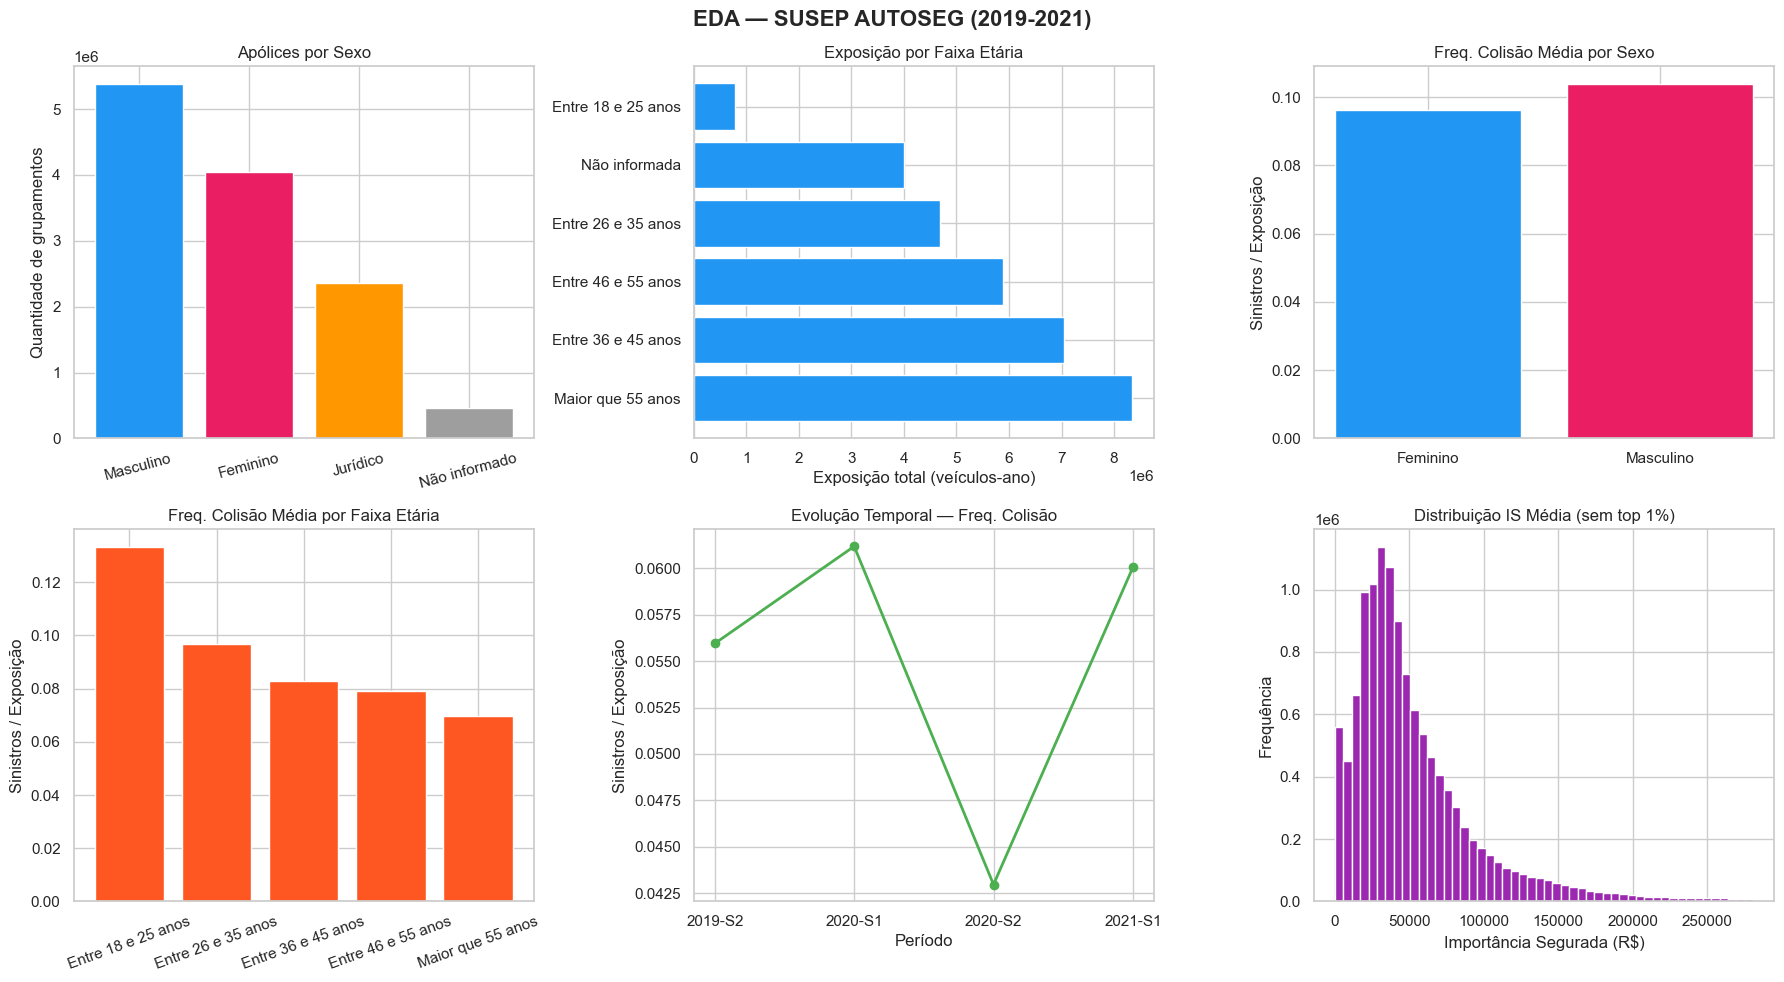

Figura salva.


In [7]:
# ============================================================
# 6. VISUALIZAÇÕES EDA
# ============================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('EDA — SUSEP AUTOSEG (2019-2021)', fontsize=16, fontweight='bold')

# 1. Apólices por sexo
ax1 = axes[0, 0]
sexo_counts = df['sexo_desc'].value_counts()
ax1.bar(sexo_counts.index, sexo_counts.values,
        color=['#2196F3','#E91E63','#FF9800','#9E9E9E'])
ax1.set_title('Apólices por Sexo')
ax1.set_ylabel('Quantidade de grupamentos')
ax1.tick_params(axis='x', rotation=15)

# 2. Exposição por faixa etária
ax2 = axes[0, 1]
idade_counts = df.groupby('faixa_etaria_desc')['exposicao'].sum().sort_values(ascending=False)
ax2.barh(idade_counts.index, idade_counts.values, color='#2196F3')
ax2.set_title('Exposição por Faixa Etária')
ax2.set_xlabel('Exposição total (veículos-ano)')

# 3. Frequência de colisão por sexo (PF apenas)
ax3 = axes[0, 2]
df_pf = df[df['sexo'].isin(['M', 'F'])].copy()
df_pf['freq_colisao_rel'] = df_pf['freq_colisao'] / df_pf['exposicao']
freq_sexo = df_pf.groupby('sexo_desc')['freq_colisao_rel'].mean()
ax3.bar(freq_sexo.index, freq_sexo.values, color=['#2196F3','#E91E63'])
ax3.set_title('Freq. Colisão Média por Sexo')
ax3.set_ylabel('Sinistros / Exposição')

# 4. Frequência de colisão por faixa etária
ax4 = axes[1, 0]
ordem_idades = ['Entre 18 e 25 anos','Entre 26 e 35 anos',
                'Entre 36 e 45 anos','Entre 46 e 55 anos','Maior que 55 anos']
df_idades = df[df['faixa_etaria'] > 0].copy()
df_idades['freq_colisao_rel'] = df_idades['freq_colisao'] / df_idades['exposicao']
freq_idade = df_idades.groupby('faixa_etaria_desc')['freq_colisao_rel'].mean().reindex(ordem_idades)
ax4.bar(freq_idade.index, freq_idade.values, color='#FF5722')
ax4.set_title('Freq. Colisão Média por Faixa Etária')
ax4.set_ylabel('Sinistros / Exposição')
ax4.tick_params(axis='x', rotation=20)

# 5. Evolução temporal
ax5 = axes[1, 1]
freq_tempo = df.groupby('periodo').apply(
    lambda x: x['freq_colisao'].sum() / x['exposicao'].sum()
).sort_index()
ax5.plot(freq_tempo.index, freq_tempo.values, marker='o', color='#4CAF50', linewidth=2)
ax5.set_title('Evolução Temporal — Freq. Colisão')
ax5.set_ylabel('Sinistros / Exposição')
ax5.set_xlabel('Período')

# 6. Distribuição IS Média
ax6 = axes[1, 2]
is_filtrado = df[df['is_media'] < df['is_media'].quantile(0.99)]['is_media']
ax6.hist(is_filtrado, bins=50, color='#9C27B0', edgecolor='white')
ax6.set_title('Distribuição IS Média (sem top 1%)')
ax6.set_xlabel('Importância Segurada (R$)')
ax6.set_ylabel('Frequência')

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, '01_eda_overview.png'), dpi=150, bbox_inches='tight')
plt.show()
print("Figura salva.")

In [9]:
# ============================================================
# 7. SALVAR DADOS PROCESSADOS
# ============================================================

output_path = os.path.join(PROCESSED_PATH, 'autoseg_limpo.parquet')
df.to_parquet(output_path, index=False)
print(f"✓ Dados salvos em {output_path}")
print(f"  Shape: {df.shape}")
print(f"  Colunas: {df.columns.tolist()}")

✓ Dados salvos em ../data/processed\autoseg_limpo.parquet
  Shape: (12244283, 27)
  Colunas: ['regiao', 'cod_modelo', 'ano_modelo', 'sexo', 'faixa_etaria', 'exposicao', 'premio', 'is_media', 'freq_roubo', 'indeniz_roubo', 'freq_colisao_parcial', 'indeniz_colisao_parcial', 'freq_colisao_total', 'indeniz_colisao_total', 'freq_incendio', 'indeniz_incendio', 'freq_outras', 'indeniz_outras', 'ano', 'semestre', 'sexo_desc', 'faixa_etaria_desc', 'freq_colisao', 'indeniz_colisao', 'sinistro_total', 'indeniz_total', 'periodo']
